# Using Tensorboard
-----------------------------
We illustrate the various uses of Tensorboard in this script.

 1. Visualizing a scalar value.
 2. Visualizing a histogram of values.
 3. Adding a custom matplotlib graph to Tensorboard

We start by loading the necessary libraries

In [2]:
import os
import io
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

Start a graph session:

In [3]:
sess = tf.Session()

We start by creating an object on our graph that will write the Tensorboard summaries to a file.  When we call this operation we will then be able to view the updated graph instantly in Tensorboard.

We run the script `01_using_tensorboard.py` from the command line via:

`$ python3 01_using_tensorboard.py`

We then start the Tensorboard application by running the command:

`$ tensorboard --logdir="tensorboard"`

Then we navigate our browser to the folling link:

http://127.0.0.0:6006

Note that we can specify a different port if need be by passing a `--port 6007` command (for running on port 6007.

In [4]:
# Create a visualizer object
summary_writer = tf.summary.FileWriter('tensorboard', tf.get_default_graph())

# Create tensorboard folder if not exists
if not os.path.exists('tensorboard'):
    os.makedirs('tensorboard')

Tensorboard will be viewable _*as*_ your program is running, so we should slow down our algorithm so that we have time to run the above tensorboard commands and load tensorboard.

In [5]:
# Wait a few seconds for user to run tensorboard commands
time.sleep(5)

Set the algorithm parameteres

In [6]:
batch_size = 50
generations = 100

For the model, we will create a linear regression fit to generated data.

In [7]:
# Create sample input data
x_data = np.arange(1000)/10.
true_slope = 2.
y_data = x_data * true_slope + np.random.normal(loc=0.0, scale=25, size=1000)

# Split into train/test
train_ix = np.random.choice(len(x_data), size=int(len(x_data)*0.9), replace=False)
test_ix = np.setdiff1d(np.arange(1000), train_ix)
x_data_train, y_data_train = x_data[train_ix], y_data[train_ix]
x_data_test, y_data_test = x_data[test_ix], y_data[test_ix]

Now we declare the placeholders, variables, model operations, loss, and optimization function.

In [8]:
# Declare placeholders
x_graph_input = tf.placeholder(tf.float32, [None])
y_graph_input = tf.placeholder(tf.float32, [None])

# Declare model variables
m = tf.Variable(tf.random_normal([1], dtype=tf.float32), name='Slope')

# Declare model
output = tf.multiply(m, x_graph_input, name='Batch_Multiplication')

# Declare loss function (L1)
residuals = output - y_graph_input
l1_loss = tf.reduce_mean(tf.abs(residuals), name="L1_Loss")

# Declare optimization function
my_optim = tf.train.GradientDescentOptimizer(0.01)
train_step = my_optim.minimize(l1_loss)

Here we show how to log a scalar variable with Tensorboard.

In [9]:
# Visualize a scalar
with tf.name_scope('Slope_Estimate'):
    tf.summary.scalar('Slope_Estimate', tf.squeeze(m))

<a href="url"><img src="https://github.com/nfmcclure/tensorflow_cookbook/raw/master/11_More_with_TensorFlow/images/01_tensorboard1.png" align="left" height="450" width="450" ></a>

Here we show how to visualize a vector of parameters with a histogram summary.

In [10]:
# Visualize a histogram (errors)
with tf.name_scope('Loss_and_Residuals'):
    tf.summary.histogram('Histogram_Errors', l1_loss)
    tf.summary.histogram('Histogram_Residuals', residuals)

<a href="url"><img src="https://github.com/nfmcclure/tensorflow_cookbook/raw/master/11_More_with_TensorFlow/images/01_tensorboard2.png" align="left" height="450" width="450" ></a>

We now create a summary merge operation that combines all the summary calculating operations into one.

In [11]:
# Declare summary merging operation
summary_op = tf.summary.merge_all()

Initialize the variables

In [12]:
# Initialize Variables
init = tf.global_variables_initializer()
sess.run(init)

We now optimize our linear regression.

Also for every iteration we will call the summary writer to write the summaries we have created to the Tensorboard directory.

(Also note that we have a `time.sleep(0.5)` in the loop.  This is to slow down the algorithm to view it in progress in Tensorboard)

In [13]:
for i in range(generations):
    batch_indices = np.random.choice(len(x_data_train), size=batch_size)
    x_batch = x_data_train[batch_indices]
    y_batch = y_data_train[batch_indices]
    _, train_loss, summary = sess.run([train_step, l1_loss, summary_op],
                             feed_dict={x_graph_input: x_batch,
                                        y_graph_input: y_batch})
    
    test_loss, test_resids = sess.run([l1_loss, residuals], feed_dict={x_graph_input: x_data_test,
                                                                       y_graph_input: y_data_test})
    
    if (i+1)%10==0:
        print('Generation {} of {}. Train Loss: {:.3}, Test Loss: {:.3}.'.format(i+1, generations, train_loss, test_loss))

    log_writer = tf.summary.FileWriter('tensorboard')
    log_writer.add_summary(summary, i)
    time.sleep(0.5)

Generation 10 of 100. Train Loss: 17.6, Test Loss: 19.0.
Generation 20 of 100. Train Loss: 20.9, Test Loss: 18.8.
Generation 30 of 100. Train Loss: 24.6, Test Loss: 18.8.
Generation 40 of 100. Train Loss: 22.2, Test Loss: 19.4.
Generation 50 of 100. Train Loss: 20.7, Test Loss: 19.9.
Generation 60 of 100. Train Loss: 19.5, Test Loss: 18.9.
Generation 70 of 100. Train Loss: 18.5, Test Loss: 19.2.
Generation 80 of 100. Train Loss: 16.5, Test Loss: 19.2.
Generation 90 of 100. Train Loss: 18.0, Test Loss: 18.9.
Generation 100 of 100. Train Loss: 23.9, Test Loss: 18.8.


Next, we will illustrate how to put a custom graph into Tensorboard.  For this example we will write the final graph of the linear regression.

First we need to create a function that generates the linear plot in a protobuf format.

In [14]:
#Create a function to save a protobuf bytes version of the graph
def gen_linear_plot(slope):
    linear_prediction = x_data * slope
    plt.plot(x_data, y_data, 'b.', label='data')
    plt.plot(x_data, linear_prediction, 'r-', linewidth=3, label='predicted line')
    plt.legend(loc='upper left')
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    return(buf)

Here we add the image to Tensorboard.

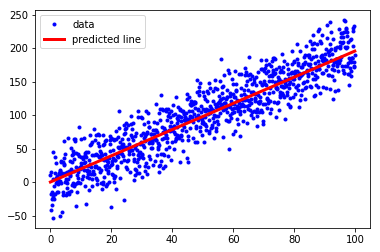

In [15]:
# Add image to tensorboard (plot the linear fit!)
slope = sess.run(m)
plot_buf = gen_linear_plot(slope[0])

# Convert PNG buffer to TF image
image = tf.image.decode_png(plot_buf.getvalue(), channels=4)

# Add the batch dimension
image = tf.expand_dims(image, 0)

# Add image summary
image_summary_op = tf.summary.image("Linear_Plot", image)
image_summary = sess.run(image_summary_op)
log_writer.add_summary(image_summary, i)
log_writer.close()

<a href="url"><img src="https://github.com/nfmcclure/tensorflow_cookbook/raw/master/11_More_with_TensorFlow/images/01_tensorboard3.png" align="left" height="450" width="450" ></a>